In [1]:
################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits

import scipy
from scipy.signal import butter,filtfilt

import sktime as skt

from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_2d_array, is_nested_dataframe

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter
import joblib
from joblib import Parallel, delayed, dump, load

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

################################
# Initialisers
################################
default_rc_params = (16,5)
plt.rcParams["figure.figsize"] = default_rc_params
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")
xNaNs = np.load("X_NAN_LIST.npy")
xTime = np.load("X_TIME_LIST.npy")

In [2]:
########################################

def GetLCData(rndFile=-1, outputFileName=False):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        tess_bjds     = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    
    if outputFileName:
        return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], rndFile)
    else:
        return (tess_bjds[1:-1], pdcsap_fluxes[1:-1])

########################################

def Every_Nth_Value(x,y,n):
    return (x[::n], y[::n])

########################################

def FixDataGaps__OLD(x,y):

    # Re-make the X array
    dt      = np.diff(x)[0]
    betterX = np.arange(min(x), max(x), dt)                  # For some reason, x has NaNs in it, this makes a new, linear x scale
    
    # Change values in Y array, where X was NaN,
    # to the median value of the function
    yMedian = np.median(y)                                   # Get the median value of 'y' before changing it
    y[np.isnan(x)] = yMedian                                 # Change all the missing values to the median value of the whole array
    
    return (betterX, y)

########################################

def FilterMyData__OLD(x,y):

    # First, fix data
    betterX, betterY = FixDataGaps(x,y)
    
    # Frequency Data Stuff
    sec           = (max(betterX)-min(betterX))*24*60*60     # Number of seconds in the overall observation period
    freq          = len(betterX)/sec                         # Frequency, in Hz, ie number of observations per second
    cutoff        = 0.1*freq                                 # HYPERPARAMETER MAYBE???????? (has to be 0 < cutoff < 0.5 because of how normal cutoff works)
    
    order         = 2                                        # Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    
    # Butter Lowpass Filter
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newY          = filtfilt(b, a, betterY)
    
    # Finally, return the new X and Y values
    return (betterX, newY)

########################################

#def FixDataGaps(y,xnan):
#    
#    yMedian = np.median(y)                                            # Get the median value of 'y' before changing it
#    y = [yMedian if n in xnan else x for n,x in enumerate(y)]         # Change all the missing values to the median value of the whole array
#    
#    return (y)

########################################

def GetNumDays():
    
    xTime = np.load("X_TIME_LIST.npy")
    nDays = xTime[-1]-xTime[0]
    
    return (nDays)

########################################

def FilterMyData(y,cutVAR=0.00005,order=2):
    
    # TEST FILTERING FIRST
    y = NormaliseFlux(y)
    
    # First, let's calculate the observational time period;
    # This is done separately so that I can change this in the future for any TESS fits file
    numdays       = GetNumDays()
    
    # Next, fix data                           
    yMedian       = np.median(y)                                                    # Get the median value of 'y' before changing it
    y             = [yMedian if n in xNaNs else item for n,item in enumerate(y)]    # Change all the missing values to the median value of the whole array
    
    # Frequency Data Stuff
    sec           = numdays*24*60*60   # Number of seconds in the overall observation period
    freq          = len(y)/sec         # Frequency, in Hz, ie number of observations per second
    # FREQ IS APPROX 1/120 OR ~0.008333333
    
    #cutoff        = cutVAR*freq        # HYPERPARAMETER NOW!!!!!!!! (has to be 0 < cutoff < 0.5 because of how normal cutoff works)
    cutoff        = cutVAR
    
    #order         = 2                  # Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    
    # Butter Lowpass Filter
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newY          = filtfilt(b, a, y)
    
    # Finally, return the new X and Y values
    return (newY)

########################################

def NormaliseFlux(f):
    
    # Normalise the Flux (y co-ords)
    median = np.median(f)
    f[:] = [(number/median) for number in f]
    
    # Return nornalised flux
    return (f)

########################################

def FIXNAN(y, xNaNs):
    yMedian = np.median(y)
    y = [yMedian if n in xNaNs else item for n,item in enumerate(y)]
    return y

########################################

In [3]:
n = 10279

x,y = GetLCData(n)

In [4]:
#np.save("X_TIME_LIST",x)
#Y_ZEROS = [item for sublist in np.argwhere(np.isnan(x)) for item in sublist]
#np.save("X_NAN_LIST", Y_ZEROS)

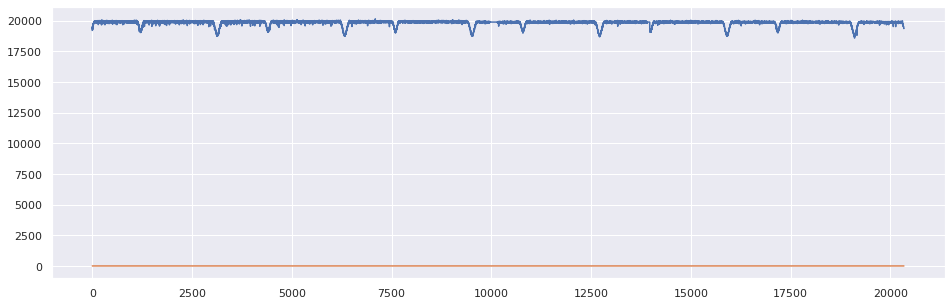

In [5]:
plt.plot(FIXNAN(y,xNaNs))
newY = FilterMyData(y)
plt.plot(newY)

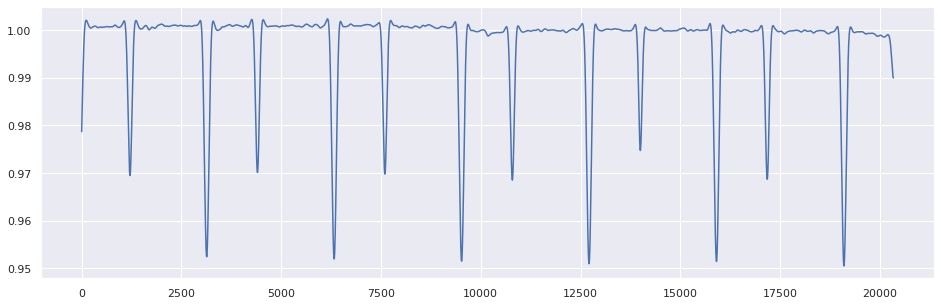

In [17]:
# MAKING CUSTOM TRANSFORMERS WORK

transformer = FunctionTransformer(FilterMyData)
a = transformer.transform(y)
plt.plot(a)

Text(0.5, 1.0, 'Fits File Number 10279')

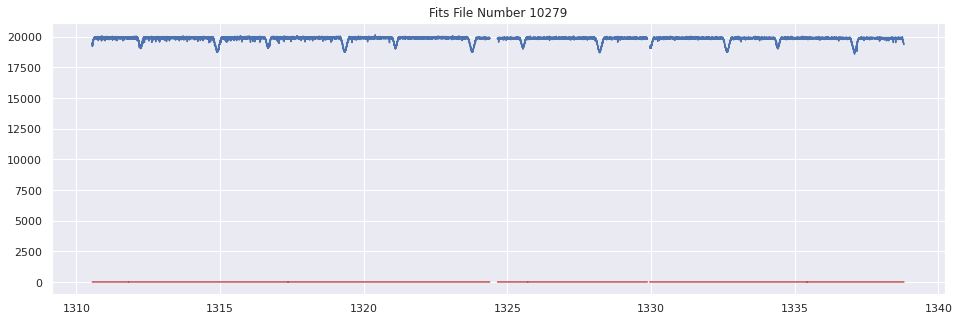

In [18]:
tmpX, tmpY, f = GetLCData(10279,True)
plt.plot(tmpX,tmpY)

newY = FilterMyData(tmpY)
plt.plot(tmpX,newY, 'r-')

plt.title(f"Fits File Number {f}")

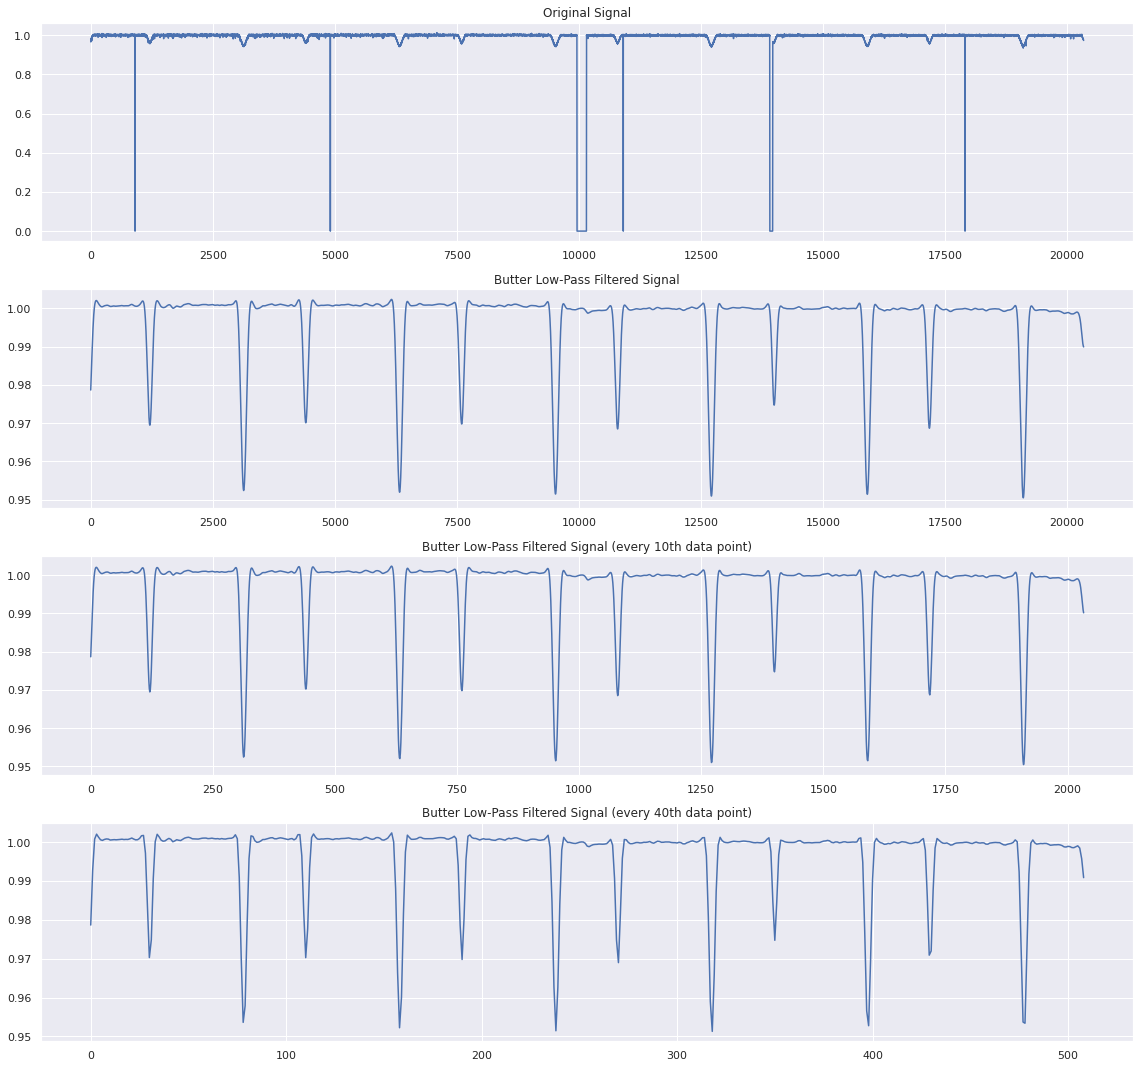

In [24]:
plt.rcParams["figure.figsize"] = (16,15)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False)

ax1.plot(tmpY)
ax1.set_title('Original Signal')
#ax1.set_xlabel('Time [Days (TBJD)]')

ax2.plot(newY)
ax2.set_title('Butter Low-Pass Filtered Signal')
#ax2.set_xlabel('Time [Days (TBJD)]')

ax3.plot(newY[::10])
ax3.set_title('Butter Low-Pass Filtered Signal (every 10th data point)')
#ax3.set_xlabel('Time [Days (TBJD)]')

ax4.plot(newY[::40])
ax4.set_title('Butter Low-Pass Filtered Signal (every 40th data point)')
#ax4.set_xlabel('Time [Days (TBJD)]')

plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = default_rc_params

Look at spectrum to determin evert nth falue!

In [7]:
def FTTMyData(y):
    """
    Function that takes in a timeseries and then outputs a Fourier Transformed version of it
    """
    
    # FOURIER TRANSFORM THAT Y (remember to use np.nanmean instead of np.mean)
    FTY = np.fft.fft(y-np.mean(y))
    powSpectrum = np.abs(FTY)
    
    #plt.plot(F,powSpectrum)
    return(powSpectrum)

(0.0, 1000.0)

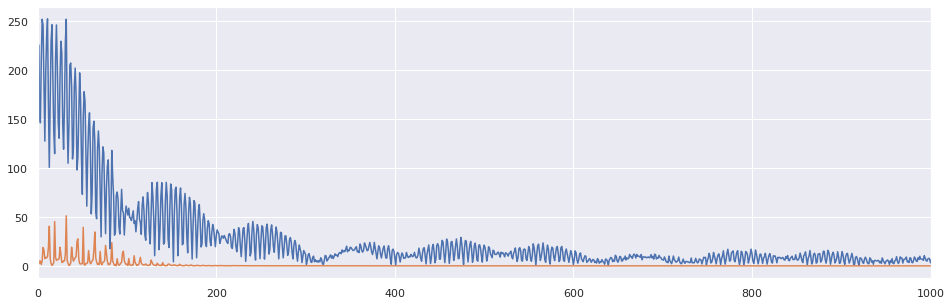

In [26]:
plt.plot(FTTMyData(tmpY))
plt.plot(FTTMyData(newY))
plt.xlim([0,1000])

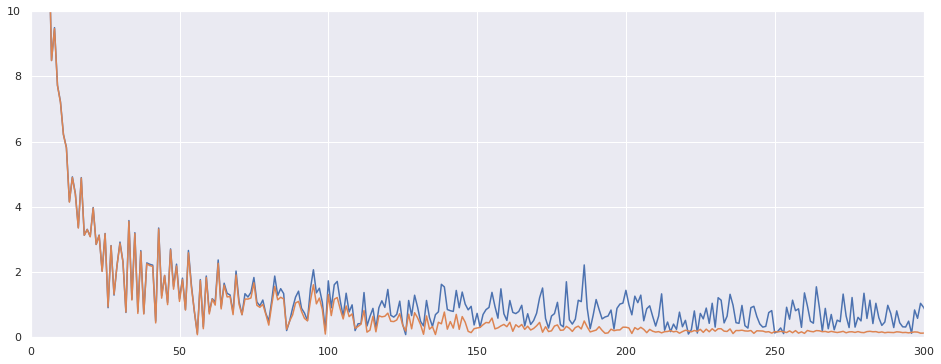

In [13]:
plt.rcParams["figure.figsize"] = (16,6)

LC = 5503

tmpX, tmpY, f = GetLCData(LC,True)
xNaNs = np.load("X_NAN_LIST.npy")
fixedY = FIXNAN(tmpY,xNaNs)
#plt.plot(fixedY)
filtY = FilterMyData(fixedY,cutVAR=0.00005, order=2)
plt.plot(FTTMyData(fixedY))
plt.plot(FTTMyData(filtY))
plt.xlim([0,300])
plt.ylim([0,10])

plt.rcParams["figure.figsize"] = default_rc_params

plt.savefig("./img/powerspectrum.png")

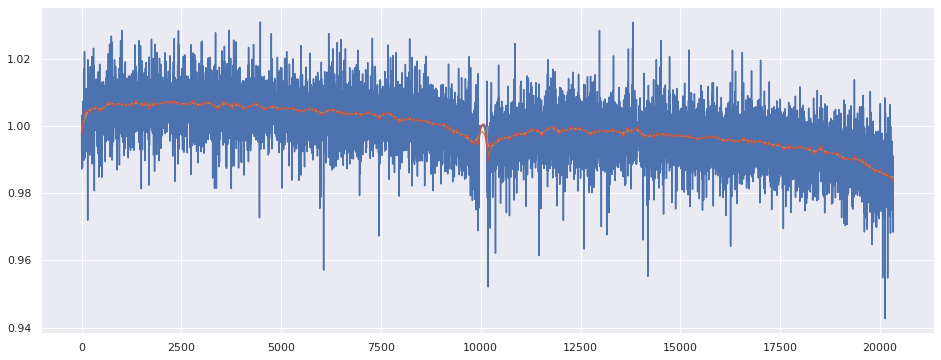

In [28]:
plt.plot(fixedY)
plt.plot(FilterMyData(fixedY,cutVAR=0.00002, order=2))
plt.plot(FilterMyData(fixedY,cutVAR=0.00004, order=2))
plt.plot(FilterMyData(fixedY,cutVAR=0.00006, order=2))
#plt.plot(FilterMyData(fixedY,cutVAR=0.00005, order=3))
#plt.plot(FilterMyData(fixedY,cutVAR=0.00005, order=5))
#plt.xlim([12000,13500])

# 0 and Nyq freq (in principal) are endpoints

# NTH IS RATIO OF NUM DATAPOINTS TO HIGHEST RESOLVABLE FREQ

If max freq is, say, 250 (when doing PowSpec) then twice that is 500, and if we have 20000 DPs then 20000/500 = 40 BOOM MAGIC/

FOR DEFAULT FILT VARS:  
LT 50, signals = same  
GT 250, signal = 0  
Midpt = 150  
  
See if can find are under curve!

In [34]:
len(y)

20338

In [38]:
len(y)*0.00005

1.0169000000000001

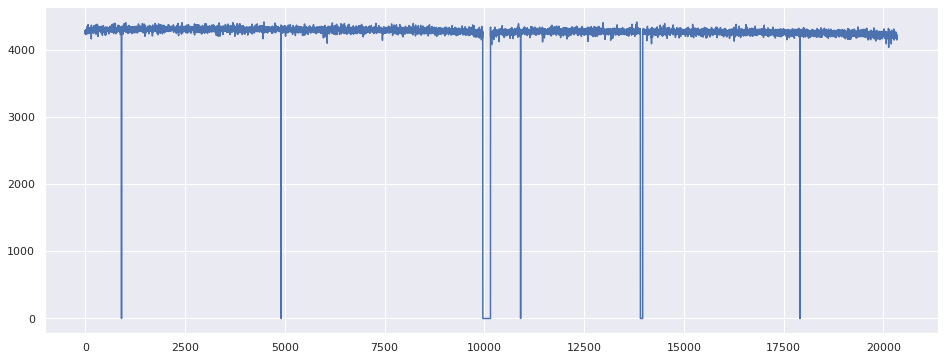

In [30]:
plt.plot(tmpY)

# Every 10th value is perfectly adequate

In [ ]:
len(GetFlux(fitsarr[0]))

20338

In [ ]:
def GetFlux(f):
    
    with fits.open(f, mode="readonly") as hdulist:
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    return (pdcsap_fluxes[1:-1])

In [ ]:
def FilterAllFluxes(f,n):
    
    # Get Flux
    flux = GetFlux(f)                # Get regular Flux
    filtFlux = FilterMyData(flux)    # Filter the data
    filtFlux = filtFlux[::n]        # Keep only every 10th datapoint

    # Manage Printing Percentage Completion
#    if i%(len(fitsarr)/100)==0:
#        print(f"{(i/160)+1} percent complete")
    
    return (filtFlux)

In [ ]:
list_of_filtered_fluxes = np.zeros((len(fitsarr[:50]),len(GetFlux(fitsarr[0])[::10])))
every_nth_pt = 10

In [ ]:
# Start Loop
for idx,dat in enumerate(fitsarr[:50]):
    list_of_filtered_fluxes[idx] = Parallel(n_jobs=10)(delayed(FilterAllFluxes)(dat,every_nth_pt) for dat in [dat])[0]

    list_of_filtered_fluxes = list_of_filtered_fluxes.astype('>f4')

KeyboardInterrupt: 

In [ ]:
list_of_filtered_fluxes

In [ ]:
Q=list_of_filtered_fluxes[0]

W = GetFlux(fitsarr[0])

In [14]:
cutoffLIST = np.linspace(0.000001,0.00001,10,True)
cutoffLIST

array([1.e-06, 2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06,
       9.e-06, 1.e-05])

In [15]:
freq = 0.000246
nyq  = 0.5 * freq

In [16]:
for i in cutoffLIST:
    normal_cutoff = i / nyq
    print(f"i: {i:8f} --- normal_cutoff: {normal_cutoff:.6f}")

i: 0.000001 --- normal_cutoff: 0.008130
i: 0.000002 --- normal_cutoff: 0.016260
i: 0.000003 --- normal_cutoff: 0.024390
i: 0.000004 --- normal_cutoff: 0.032520
i: 0.000005 --- normal_cutoff: 0.040650
i: 0.000006 --- normal_cutoff: 0.048780
i: 0.000007 --- normal_cutoff: 0.056911
i: 0.000008 --- normal_cutoff: 0.065041
i: 0.000009 --- normal_cutoff: 0.073171
i: 0.000010 --- normal_cutoff: 0.081301
